## Enunciado

>Considere el proyecto cuya información se adjunta.
> 1. Dibuje el grafo PERT y determine el camino crítico.
> 2. Indique sus actuaciones si existiera un límite de disponibilidad de recursos durante los primeros 7 periodos igual a 3 unidades.
> 3. Indique sus actuaciones para reducir la duración del proyecto hasta 28 periodos con un mínimo sobrecoste añadido.
> 4. Indique sus actuaciones para reducir la duración del proyecto hasta su duración tope con un mínimo sobrecoste añadido.
> 5. Duración del proyecto si se introducen los siguientes cambios:
>      - Entre el final de la actividad H y el comienzo de la L deben transcurrir 2 periodos.
>      - La tarea K se inicia cuando F está a mitad de su ejecución


In [1]:
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"

import os, sys

if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files

# To find local version of the library
sys.path.append('pmULE/src')

from pmule import PredecessorTable, ProjectGraph



Cloning repository 'pmULE'...
Cloning into 'pmULE'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 299 (delta 64), reused 7 (delta 2), pack-reused 191 (from 1)
Receiving objects: 100% (299/299), 10.15 MiB | 16.26 MiB/s, done.
Resolving deltas: 100% (165/165), done.
Repository cloned successfully!


In [2]:
# Alargamos el ancho de las celdas al 100%
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

import numpy as np

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, duracion, duracion_tope, cur, recursos
     ('A',       '---  ',     4,         1,          25,     2    ),
     ('B',       'A    ',     4,         1,          25,     1    ),
     ('C',       'A    ',     5,         2,          20,     2    ),
     ('D',       'A    ',     4,         1,          10,     2    ),
     ('E',       'A    ',     3,         2,          50,     2    ),
     ('F',       'D,E  ',     6,         3,          30,     4    ),
     ('G',       'F    ',     4,         1,          25,     1    ),
     ('H',       'B,C,G',     7,         4,          20,     1    ),
     ('I',       'C,G  ',     5,         2,          20,     3    ),
     ('J',       'I    ',     4,         1,          25,     4    ),
     ('K',       'F    ',     4,         1,          25,     1    ),
     ('L',       'H    ',     8,         5,          10,     2    ),
     ('M',       'I,K  ',     4,         1,          25,     1    ),

] ,columns=['activity', 'predecessor', 'duration', 'cap_duration', 'ucr', 'resources']).set_index('activity')

datos_enunciado

,predecessor,duration,cap_duration,ucr,resources
activity,,,,,
A,---,4,1,25,2
B,A,4,1,25,1
C,A,5,2,20,2
D,A,4,1,10,2
E,A,3,2,50,2
F,"D,E",6,3,30,4
G,F,4,1,25,1
H,"B,C,G",7,4,20,1
I,"C,G",5,2,20,3


## Solución
### Apartado 1

> Dibuje el grafo PERT y determine el camino crítico.

En pmule (project management at ULE) está el código que utilizamos para calcular los valores del PERT.

In [3]:
from pmule import PredecessorTable, ProjectGraph

In [4]:
datos_proyecto = datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessor')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K,L,M
activities,,,,,,,,,,,,,
A,,,,,,,,,,,,,
B,True,,,,,,,,,,,,
C,True,,,,,,,,,,,,
D,True,,,,,,,,,,,,
E,True,,,,,,,,,,,,
F,,,,True,True,,,,,,,,
G,,,,,,True,,,,,,,
H,,True,True,,,,True,,,,,,
I,,,True,,,,True,,,,,,


La clase PertGraph permite visualizar el grafo PERT, el diagrama de Gantt así como realizar el cálculo de tiempos tempranos, tardíos y de las holguras totales.

##### Grafo PERT con numeración de nodos

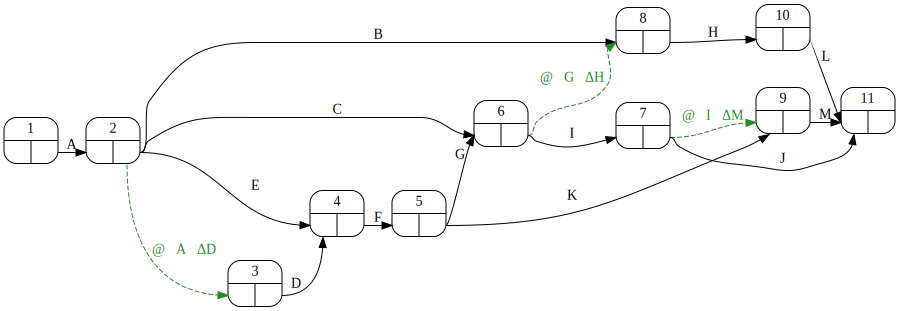

In [5]:
proyecto = prelaciones.create_project()
proyecto.pert(ranksep=0.25)

##### Matriz de Zaderenko

In [6]:
proyecto.zaderenko(datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,9,10,11,early
1,,4.0,,,,,,,,,,0.0
2,,,0.0,3.0,,5.0,,4.0,,,,4.0
3,,,,4.0,,,,,,,,4.0
4,,,,,6.0,,,,,,,8.0
5,,,,,,4.0,,,4.0,,,14.0
6,,,,,,,5.0,0.0,,,,18.0
7,,,,,,,,,0.0,,4.0,23.0
8,,,,,,,,,,7.0,,18.0
9,,,,,,,,,,,4.0,23.0
10,,,,,,,,,,,8.0,25.0


In [7]:
resultados_pert = proyecto.calculate_pert(datos_proyecto['duration'])
resultados_pert['nodes']

,early,late
1,0,0
2,4,4
3,4,4
4,8,8
5,14,14
6,18,18
7,23,29
8,18,18
9,23,29
10,25,25


##### Holguras

In [8]:
resultados_pert['activities']

,H_total
@∇A⤑ΔD,0
@∇G⤑ΔH,0
@∇I⤑ΔM,6
A,0
B,10
C,9
D,0
E,1
F,0
G,0


###### Camino crítico

In [9]:
camino_critico = proyecto.critical_path(datos_proyecto['duration'])
camino_critico

{'Route_11': ['A', '@∇A⤑ΔD', 'D', 'F', 'G', '@∇G⤑ΔH', 'H', 'L']}

##### Grafo PERT con indicación de tiempos

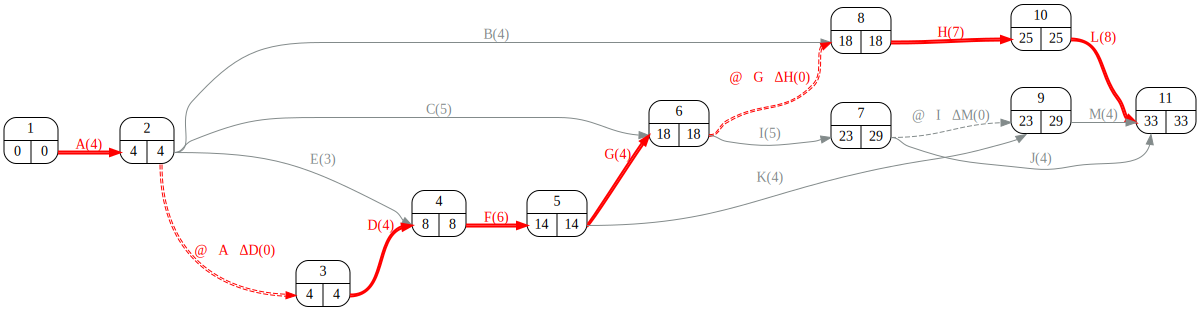

In [10]:
proyecto.pert(durations=datos_proyecto['duration'])

### Apartado 2
> Indique sus actuaciones si existiera un límite de disponibilidad de recursos durante los primeros 7 periodos igual a 3 unidades.

#### Situación inicial
Para responder este apartado es necesario representar la demanda de recursos a lo largo del tiempo.

In [11]:
proyecto_asignacion = proyecto.copy()
gantt_recursos = proyecto_asignacion.gantt(datos_proyecto, 'duration', 'resources', total='fila', holguras = True)
gantt_recursos

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,H_total
A,2,2,2,2,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.000000
B,,,,,1,1,1,1,,,,,,,,,,,,,,,,,,,,,,,,,,10.000000
C,,,,,2,2,2,2,2,,,,,,,,,,,,,,,,,,,,,,,,,9.000000
D,,,,,2,2,2,2,,,,,,,,,,,,,,,,,,,,,,,,,,0.000000
E,,,,,2,2,2,,,,,,,,,,,,,,,,,,,,,,,,,,,1.000000
F,,,,,,,,,4,4,4,4,4,4,,,,,,,,,,,,,,,,,,,,0.000000
G,,,,,,,,,,,,,,,1,1,1,1,,,,,,,,,,,,,,,,0.000000
H,,,,,,,,,,,,,,,,,,,1,1,1,1,1,1,1,,,,,,,,,0.000000
I,,,,,,,,,,,,,,,,,,,3,3,3,3,3,,,,,,,,,,,6.000000
J,,,,,,,,,,,,,,,,,,,,,,,,4,4,4,4,,,,,,,6.000000


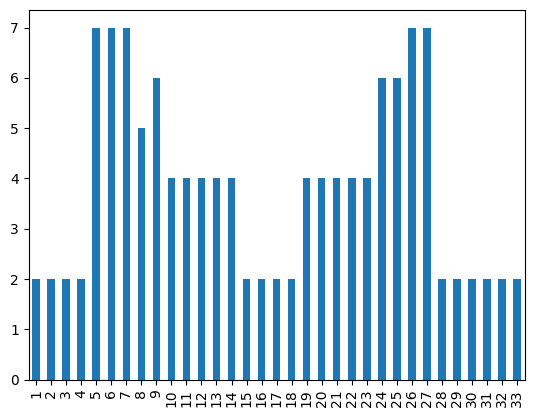

In [12]:
(gantt_recursos.data.loc['Total'].drop('H_total').plot(kind='bar'));

La demanda de recursos actual infringe el límite impuesto durante los primeros 7 periodos. Es necesario aplicar el algoritmo de asignación.

#### Algoritmo de asignación

 El primer periodo problemático es el 5.

##### Asignación periodo 5

De las actividades inicialmente programadas para el periodo 5, la tarea D es crítica y por tanto se prefiere mantener su ejecución en tal fecha. Esto implica programar 2 recursos para ese periodo. Del resto de actividades tan sólo puede programar la B por consumir 1 recurso y ya completar alcanzar el límite de 3 recursos.

In [13]:
duracion_y_recursos = datos_proyecto[['duration', 'resources']]
duracion_y_recursos = proyecto_asignacion.desplazar(duracion_y_recursos, 'duration', 'resources', C = 1, E = 1)


Suma de cuadrados: 598.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,H_total
A,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.000000
B,,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,,,,,,,,,,,,,,,,,,10.000000
C,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,,,,,,,,8.000000
D,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,,,,,,,,,,0.000000
E,,,,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,,,,,,,,,,0.000000
F,,,,,,,,,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
G,,,,,,,,,,,,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,,,,,,,,0.000000
H,,,,,,,,,,,,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,,,,,,3.000000,3.000000,3.000000,3.000000,3.000000,,,,,,,,,,,6.000000
J,,,,,,,,,,,,,,,,,,,,,,,,4.000000,4.000000,4.000000,4.000000,,,,,,,6.000000


Las actividades *slide_C* y *slide_E* representan el desplazamiento de las actividades C y E respectivamente. Nótese como la actividad E se ha vuelto crítica.

El siguiente periodo problemático es el 6.

##### Asignación periodo 6

Al encontrase en ejecución las actividades B y D se mantiene su ejecución retrasando el resto. Esto conlleva un retraso del proyecto al ser ya crítica la actividad E.

In [14]:
duracion_y_recursos = proyecto_asignacion.desplazar(duracion_y_recursos, 'duration', 'resources', C = 1, E = 1)

Suma de cuadrados: 574.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,H_total
A,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.000000
B,,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,,,,,,,,,,,,,,,,,,,11.000000
C,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,,,,,,,,8.000000
D,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,,,,,,,,,,,1.000000
E,,,,,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,,,,,,,,,,0.000000
F,,,,,,,,,,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
G,,,,,,,,,,,,,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,,,,,,,,0.000000
H,,,,,,,,,,,,,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,,,,,,,3.000000,3.000000,3.000000,3.000000,3.000000,,,,,,,,,,,6.000000
J,,,,,,,,,,,,,,,,,,,,,,,,,4.000000,4.000000,4.000000,4.000000,,,,,,,6.000000


El siguiente periodo problemático es el 7.

##### Asignación periodo 7

Al encontrase en ejecución las actividades B y D se mantiene su ejecución retrasando el resto. Esto conlleva un nuevo retraso del proyecto al ser crítica la actividad E.

In [15]:
duracion_y_recursos = proyecto_asignacion.desplazar(duracion_y_recursos, 'duration', 'resources', C = 1, E = 1)

Suma de cuadrados: 550.0 



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,H_total
A,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,0.000000
B,,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,,,,,,,,,,,,,,,,,,,,12.000000
C,,,,,,,,2.000000,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,,,,,,,,8.000000
D,,,,,2.000000,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,,,,,,,,,,,,2.000000
E,,,,,,,,2.000000,2.000000,2.000000,,,,,,,,,,,,,,,,,,,,,,,,,,0.000000
F,,,,,,,,,,,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,,,,,,,,,,,,,,,,,,,,0.000000
G,,,,,,,,,,,,,,,,,1.000000,1.000000,1.000000,1.000000,,,,,,,,,,,,,,,,0.000000
H,,,,,,,,,,,,,,,,,,,,,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,,,,,,,,,0.000000
I,,,,,,,,,,,,,,,,,,,,,3.000000,3.000000,3.000000,3.000000,3.000000,,,,,,,,,,,6.000000
J,,,,,,,,,,,,,,,,,,,,,,,,,,4.000000,4.000000,4.000000,4.000000,,,,,,,6.000000


Con las operaciones indicadas el proyecto sería compatible con la restricción en el límite de recursos disponibles impuesta en el enunciado del ejercicio.

### Apartado 3
> Indique sus actuaciones para reducir la duración del proyecto hasta 28 periodos con un mínimo sobrecoste añadido.


In [16]:
ackoff, best_option, duration, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                                                           min_durations=datos_proyecto['cap_duration'],
                                                           costs=datos_proyecto['ucr'],
                                                           reduction=5
                                                           )
ackoff

D shape (13,)
Path matrix shape (12, 13)


Step: 0,	 Best option: ['D'], 	 Cost: 10, 	 Critical paths: ['Route_11']
Step: 1,	 Best option: ['L'], 	 Cost: 10, 	 Critical paths: ['Route_7', 'Route_11']
Step: 2,	 Best option: ['L'], 	 Cost: 10, 	 Critical paths: ['Route_7', 'Route_11']
Step: 3,	 Best option: ['L'], 	 Cost: 10, 	 Critical paths: ['Route_7', 'Route_11']
Step: 4,	 Best option: ['H'], 	 Cost: 20, 	 Critical paths: ['Route_7', 'Route_11']





,A,B,C,D,E,F,G,H,I,J,K,L,M,0,1,2,3,4,5
Route_1,25.0,25.0,,,,,,20.0,,,,10.0,,23.0,23.0,22.0,21.0,20.0,19.0
Route_2,25.0,,20.0,,,,,,20.0,25.0,,,,18.0,18.0,18.0,18.0,18.0,18.0
Route_3,25.0,,20.0,,,,,,20.0,,,,25.0,18.0,18.0,18.0,18.0,18.0,18.0
Route_4,25.0,,20.0,,,,,20.0,,,,10.0,,24.0,24.0,23.0,22.0,21.0,20.0
Route_5,25.0,,,,50.0,30.0,25.0,,20.0,25.0,,,,26.0,26.0,26.0,26.0,26.0,26.0
Route_6,25.0,,,,50.0,30.0,25.0,,20.0,,,,25.0,26.0,26.0,26.0,26.0,26.0,26.0
Route_7,25.0,,,,50.0,30.0,25.0,20.0,,,,10.0,,32.0,32.0,31.0,30.0,29.0,28.0
Route_8,25.0,,,,50.0,30.0,,,,,25.0,,25.0,21.0,21.0,21.0,21.0,21.0,21.0
Route_9,25.0,,,10.0,,30.0,25.0,,20.0,25.0,,,,27.0,26.0,26.0,26.0,26.0,26.0
Route_10,25.0,,,10.0,,30.0,25.0,,20.0,,,,25.0,27.0,26.0,26.0,26.0,26.0,26.0


### Apartado 4
> Indique sus actuaciones para reducir la duración del proyecto hasta su duración tope con un mínimo sobrecoste añadido.

Calculamos la duración del proyecto utilizando las duraciones tope y posteriormente alargaremos la duración de las tareas no críticas que han sido recortadas ineficientemente.

In [17]:
ackoff, best_option, duration, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                                                           min_durations=datos_proyecto['cap_duration'],
                                                           costs=datos_proyecto['ucr'],
                                                           )
ackoff

D shape (13,)
Path matrix shape (12, 13)


Step: 0,	 Best option: ['D'], 	 Cost: 10, 	 Critical paths: ['Route_11']
Step: 1,	 Best option: ['L'], 	 Cost: 10, 	 Critical paths: ['Route_7', 'Route_11']
Step: 2,	 Best option: ['L'], 	 Cost: 10, 	 Critical paths: ['Route_7', 'Route_11']
Step: 3,	 Best option: ['L'], 	 Cost: 10, 	 Critical paths: ['Route_7', 'Route_11']
Step: 4,	 Best option: ['H'], 	 Cost: 20, 	 Critical paths: ['Route_7', 'Route_11']
Step: 5,	 Best option: ['H'], 	 Cost: 20, 	 Critical paths: ['Route_7', 'Route_11']
Step: 6,	 Best option: ['H'], 	 Cost: 20, 	 Critical paths: ['Route_7', 'Route_11']
Step: 7,	 Best option: ['A'], 	 Cost: 25, 	 Critical paths: ['Route_5', 'Route_6', 'Route_7', 'Route_9', 'Route_10', 'Route_11']
Step: 8,	 Best option: ['A'], 	 Cost: 25, 	 Critical paths: ['Route_5', 'Route_6', 'Route_7', 'Route_9', 'Route_10', 'Route_11']
Step: 9,	 Best option: ['A'], 	 Cost: 25, 	 Critical paths: ['Route_5', 'Route_6', 'Route_7', 'Route_9', 'Route_10', 'Rout

,A,B,C,D,E,F,G,H,I,J,K,L,M,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Route_1,25.0,25.0,,,,,,20.0,,,,10.0,,23.0,23.0,22.0,21.0,20.0,19.0,18.0,17.0,16.0,15.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0,14.0
Route_2,25.0,,20.0,,,,,,20.0,25.0,,,,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,17.0,16.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
Route_3,25.0,,20.0,,,,,,20.0,,,,25.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,17.0,16.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
Route_4,25.0,,20.0,,,,,20.0,,,,10.0,,24.0,24.0,23.0,22.0,21.0,20.0,19.0,18.0,17.0,16.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
Route_5,25.0,,,,50.0,30.0,25.0,,20.0,25.0,,,,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,25.0,24.0,23.0,22.0,21.0,20.0,19.0,18.0,17.0,16.0
Route_6,25.0,,,,50.0,30.0,25.0,,20.0,,,,25.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,25.0,24.0,23.0,22.0,21.0,20.0,19.0,18.0,17.0,16.0
Route_7,25.0,,,,50.0,30.0,25.0,20.0,,,,10.0,,32.0,32.0,31.0,30.0,29.0,28.0,27.0,26.0,25.0,24.0,23.0,22.0,21.0,20.0,19.0,18.0,17.0,16.0
Route_8,25.0,,,,50.0,30.0,,,,,25.0,,25.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,20.0,19.0,18.0,18.0,18.0,18.0,17.0,16.0,15.0,14.0
Route_9,25.0,,,10.0,,30.0,25.0,,20.0,25.0,,,,27.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,25.0,24.0,23.0,22.0,21.0,20.0,19.0,18.0,17.0,16.0
Route_10,25.0,,,10.0,,30.0,25.0,,20.0,,,,25.0,27.0,26.0,26.0,26.0,26.0,26.0,26.0,26.0,25.0,24.0,23.0,22.0,21.0,20.0,19.0,18.0,17.0,16.0


## Apartado 5

> Duración del proyecto si se introducen los siguientes cambios:
>   - Entre el final de la actividad H y el comienzo de la L deben transcurrir 2 periodos.
>   - La tarea K se inicia cuando F está a mitad de su ejecución

La solución de este apartado precisa:
   - Introducir una actividad ficticia tras el final de H y anterior a L con duración 2 periodos.
   - Partir la actividad F en dos partes F1 y F2 e iniciar K tras el final de F1.

In [18]:
prelaciones_modificadas =  PredecessorTable.from_dict_of_sets(
    {
          'A': set(),
          'B': {'A'},
          'C': {'A'},
          'D': {'A'},
          'E': {'A'},
          'F1': {'D', 'E'},        # This is different. F1 represents the first part of F
          'F2': {'F1'},            # This is different. F2 represents the second part of F
          'G': {'F2'},             # This is different
          'H': {'B', 'C', 'G'},
          'I': {'C', 'G'},
          'J': {'I'},
          'K': {'F1'},           # This is different
          '💤L': {'H'},         # This is different. zzzL represent the waiting period before L can start.
          'L': {'💤L'},
          'M': {'I', 'K'}
    }
)

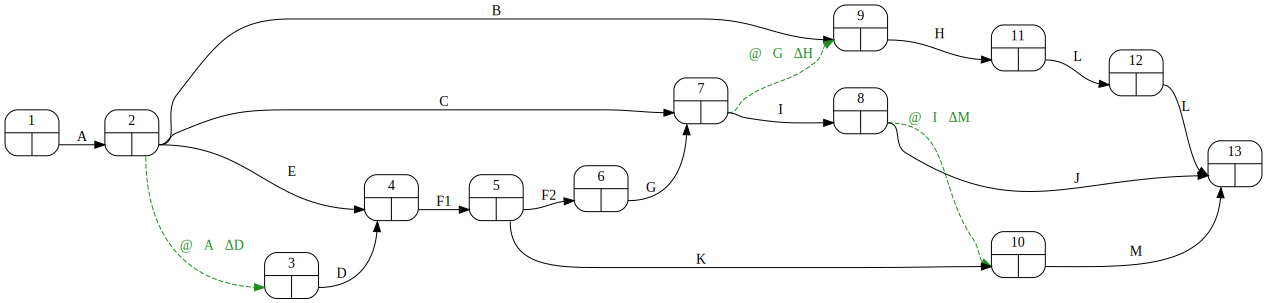

In [19]:
proyecto_modificado = prelaciones_modificadas.create_project()
proyecto_modificado.pert()

##### Grafo PERT con numeración de nodos

In [20]:
duracion_modificado = datos_proyecto['duration'].drop('F')
duracion_modificado['F1'] = 3
duracion_modificado['F2'] = 3
duracion_modificado['💤L'] = 2

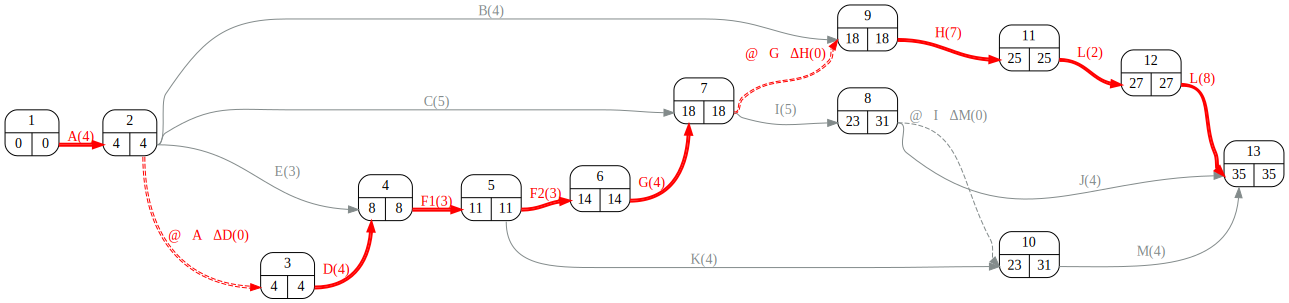

In [21]:
proyecto_modificado.pert(durations=duracion_modificado, ranksep=0.25)